In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# 数据预处理
# 1. 数据清洗，过滤不符合规则的数据
data = pd.read_csv("../LRFMC/air_data.csv", encoding="gb18030")  # 导入航空数据
print("原始数据的形状为：", data.shape)
print(data)

原始数据的形状为： (62988, 44)
       MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY   
0          54993  2006/11/2        2008/12/24      男         6            .  \
1          28065  2007/2/19          2007/8/3      男         6          NaN   
2          55106   2007/2/1         2007/8/30      男         6            .   
3          21189  2008/8/22         2008/8/23      男         5  Los Angeles   
4          39546  2009/4/10         2009/4/15      男         6           贵阳   
...          ...        ...               ...    ...       ...          ...   
62983      18375  2011/5/20          2013/6/5      女         4           广州   
62984      36041   2010/3/8         2013/9/14      男         4           佛山   
62985      45690  2006/3/30         2006/12/2      女         4           广州   
62986      61027   2013/2/6         2013/2/14      女         4           广州   
62987      61340  2013/2/17         2013/2/17      女         4           上海   

      WORK_PROVINCE WORK_COUN

In [5]:
# 要求1、丢弃票价为空的记录。 SUM_YR_1是客户在第一年乘坐该航空公司的总票价支出
data = data[data["SUM_YR_1"].notnull() & data["SUM_YR_2"].notnull()]  # 票价非空值才保留
print("第一次数据过滤后：", data.shape)

第一次数据过滤后： (62299, 44)


In [6]:
# 要求2、丢弃票价为0、平均折扣率不为0、总飞行千米数大于0的记录: 把票价不为0，飞行公里为0，平均折扣为0的找到并丢弃。
doc1 = (data["SUM_YR_1"] != 0) | (data["SUM_YR_2"] != 0)
doc2 = (data["SEG_KM_SUM"] == 0) & (data["avg_discount"] == 0)  # 飞行公里==0,平均折扣==0的
data = data[doc1 & doc2]
print("第二次数据过滤后：", data.shape)

第二次数据过滤后： (62044, 44)


In [7]:
 # L=LOAD_TIME-FFP_DATE
data["LOAD_TIME"] = pd.to_datetime(data["LOAD_TIME"])  # 要按pd.datetime格式转换时间格式
data["FFP_DATE"] = pd.to_datetime(data["FFP_DATE"])
data["会员入会时间L"] = data["LOAD_TIME"] - data["FFP_DATE"]
print(data["会员入会时间L"])

0       2706 days
1       2597 days
2       2615 days
3       2047 days
4       1816 days
           ...   
62974   3249 days
62975   1961 days
62976   1362 days
62977    466 days
62978   1082 days
Name: 会员入会时间L, Length: 62044, dtype: timedelta64[ns]


In [8]:
# 单位转化为月
mon = []
for i in data["会员入会时间L"]:
    months = int(i.days / 30)
    mon.append(months)
data["L"] = np.array(mon)
print(data["L"])

0         90
1         86
2         87
3         68
4         60
        ... 
62974    108
62975     65
62976     45
62977     15
62978     36
Name: L, Length: 62044, dtype: int32


In [1]:
#  R=LAST_TO_END
data["R"] = int(data["LAST_TO_END"] / 30)
print(data["R"])

NameError: name 'data' is not defined

In [10]:
#  F=FLIGHT_COUNT; M=SEG_KM_SUM; C=AVG_DISCOUNT
my_data = data[["L", "R", "FLIGHT_COUNT", "SEG_KM_SUM", "avg_discount"]]
my_data = my_data.rename(columns={"L": "L", "R": "R", "FLIGHT_COUNT": "F", "SEG_KM_SUM": "M", "avg_discount": "C"})
print(my_data)

         L          R    F       M         C
0       90   0.033333  210  580717  0.961639
1       86   0.233333  140  293678  1.252314
2       87   0.366667  135  283712  1.254676
3       68   3.233333   23  281336  1.090870
4       60   0.166667  152  309928  0.970658
...    ...        ...  ...     ...       ...
62974  108   2.966667    2     368  0.710000
62975   65   4.033333    2     368  0.670000
62976   45   1.300000    2    1062  0.225000
62977   15  15.466667    2     904  0.250000
62978   36   9.400000    2     760  0.280000

[62044 rows x 5 columns]


In [11]:
# 标准化处理：处理后，所有特征的均值为0，标准差为1
my_data = StandardScaler().fit_transform(my_data)
print(my_data)
np.savez("airline_scale.npz", my_data)

[[ 1.44567294 -0.94495516 14.03412875 26.76136996  1.29555058]
 [ 1.30415089 -0.9119018   9.07328567 13.1269701   2.86819902]
 [ 1.3395314  -0.88986623  8.71893974 12.65358345  2.88097321]
 ...
 [-0.14645014 -0.73561725 -0.70666211 -0.77233818 -2.68990622]
 [-1.20786553  1.6056619  -0.70666211 -0.77984321 -2.55464809]
 [-0.46487476  0.60304353 -0.70666211 -0.78668323 -2.39233833]]


In [12]:
# 读入客户数据
airline_scale = np.load('../LRFMC/airline_scale.npz')['arr_0']
print(type(airline_scale))  # ndarray类型

<class 'numpy.ndarray'>


In [13]:
# 利用kmeans算法对客户进行聚类
# 聚类中心数
k = 5
# 聚类中心数，并行的CPU核的数量，随机数种子
kmeans_model = KMeans(n_clusters=k, random_state=123)
fit_kmeans = kmeans_model.fit(airline_scale)      # 模型训练
print("聚类中心：", kmeans_model.cluster_centers_)  # 查看聚类中心
print("聚类标签：", kmeans_model.labels_)  #
# 查看样本的类别标签

D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


聚类中心： [[ 5.22885049e-02 -1.97123315e-03 -2.27135862e-01 -2.32039346e-01
   2.19002477e+00]
 [ 1.16044411e+00 -3.77275388e-01 -8.70868561e-02 -9.50703084e-02
  -1.56603970e-01]
 [ 4.83909568e-01 -7.99313562e-01  2.48432537e+00  2.42541797e+00
   3.09015085e-01]
 [-7.00408832e-01 -4.15367931e-01 -1.60719992e-01 -1.60360734e-01
  -2.54828329e-01]
 [-3.14053253e-01  1.68547839e+00 -5.73910195e-01 -5.36683767e-01
  -1.73841557e-01]]
聚类标签： [2 2 2 ... 3 4 4]


In [14]:
# 统计不同类别样本的数目
r1 = pd.Series(kmeans_model.labels_).value_counts()
print("最终每个类别的数目：\n", r1)

最终每个类别的数目：
 3    24642
1    15745
4    12131
2     5333
0     4193
Name: count, dtype: int64


In [15]:
# 测试一下：测试这一组数据会被分配在哪个类别中
result = kmeans_model.predict([[1.5, 1.5, 1.5, 1.5, 1.5]])
print(result)

[2]


In [21]:
# 对建立的Kmeans模型进行评价
# 聚类模型评价:FMI方法 [0-1] 数值越高分类效果越好
import matplotlib.pyplot as plt
fmi_scores = []
for i in range(2, 7):
    # 训练模型
    kmeans = KMeans(n_clusters=i, random_state=123).fit(airline_scale)
    score = fowlkes_mallows_score(kmeans_model.labels_, kmeans.labels_)
    print("航空公司数据聚%d类FMI评价分值为：%f" % (i, score))
    fmi_scores.append(score)

D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚2类FMI评价分值为：0.528699


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚3类FMI评价分值为：0.647869


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚4类FMI评价分值为：0.912594


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚5类FMI评价分值为：1.000000


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚6类FMI评价分值为：0.842228


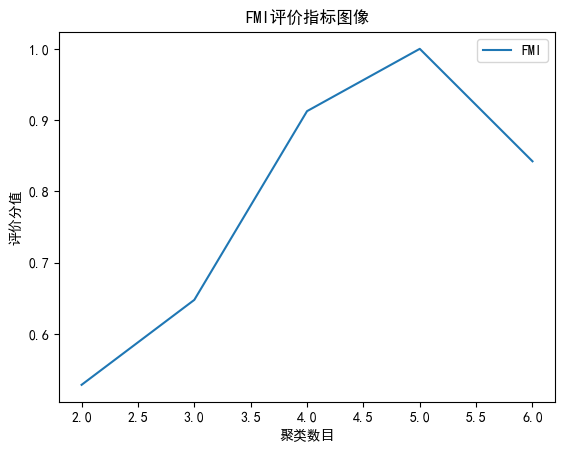

In [28]:
# 绘制评价指标图像
plt.plot(range(2, 7), fmi_scores, label='FMI')
plt.legend()
plt.title("FMI评价指标图像")
plt.xlabel("聚类数目")
plt.ylabel("评价分值")
plt.savefig("FMI评价指标分析图.jpg")
plt.show()

In [17]:
# 聚类模型评价：silhouette
silhouseScore = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, random_state=123).fit(airline_scale)
    score = silhouette_score(airline_scale, kmeans.labels_)
    print("航空公司数据聚%d类silhouette评价分值：%f" % (i, score))
    silhouseScore.append(score)

D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚2类silhouette评价分值：0.369924


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚3类silhouette评价分值：0.267254


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚4类silhouette评价分值：0.269562


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚5类silhouette评价分值：0.277339


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚6类silhouette评价分值：0.281435


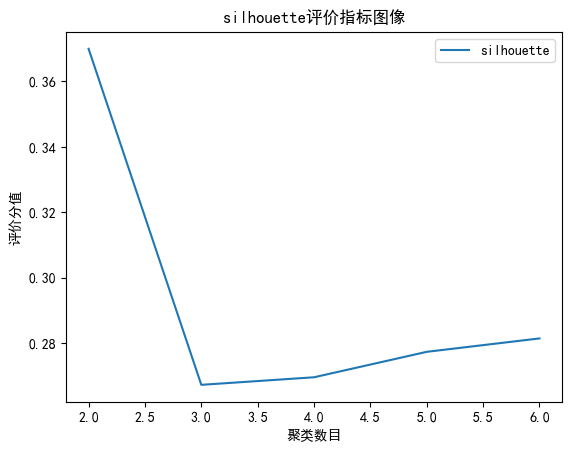

In [36]:
# 绘制评价指标图像
# Silhouette系数接近于1，则表示聚类效果较好；如果接近于-1，则表示聚类效果较差；如果接近于0，则表明聚类效果不明显
plt.plot(range(2, 7), silhouseScore, label='silhouette')
plt.legend()
plt.title("silhouette评价指标图像")
plt.xlabel("聚类数目")
plt.ylabel("评价分值")
plt.savefig("silhouette评价指标分析图.jpg")
plt.show()

In [22]:
# 聚类模型评价：calinski_harabasz
# Calinski-Harabasz指数越大时，表示聚类效果越好
ch_scores = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, random_state=123).fit(airline_scale)
    score = calinski_harabasz_score(airline_scale, kmeans.labels_)
    print("航空公司数据聚%d类calinski_harabasz评价分值：%f" % (i, score))
    ch_scores.append(score)

D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚2类calinski_harabasz评价分值：21876.166166


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚3类calinski_harabasz评价分值：21180.463809


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚4类calinski_harabasz评价分值：21800.742147


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚5类calinski_harabasz评价分值：20567.150563


D:\python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


航空公司数据聚6类calinski_harabasz评价分值：20191.660691


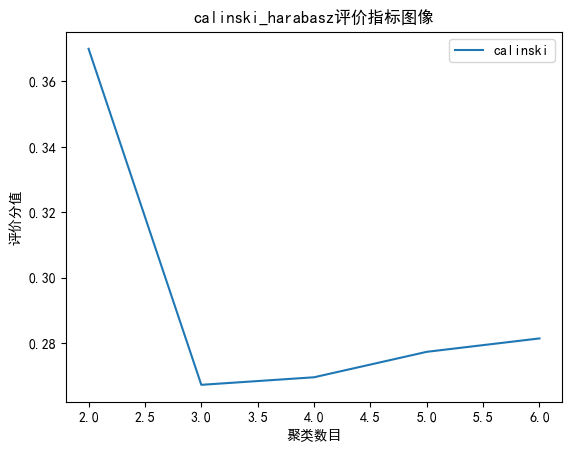

In [35]:
# 绘制评价指标图像
plt.plot(range(2, 7), silhouseScore, label='calinski')
plt.legend()
plt.title("calinski_harabasz评价指标图像")
plt.xlabel("聚类数目")
plt.ylabel("评价分值")
plt.savefig("calinski_harabasz评价指标分析图.jpg")
plt.show()

C:\Users\equ\AppData\Local\Temp\ipykernel_10688\188370517.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('客户群特征分析图.jpg')
D:\python3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


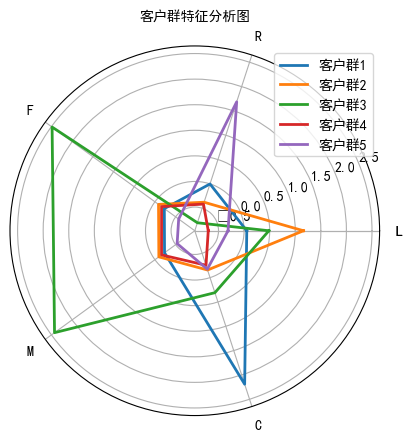

In [34]:
# 绘制客户雷达图
r = pd.Series(['客户群1', '客户群2', '客户群3', '客户群4', '客户群5'])
labels = np.array(["L", "R", "F", "M", "C"])
fig = plt.figure()
datas = kmeans_model.cluster_centers_
ax = fig.add_subplot(111, polar=True)
angles = np.linspace(0, 2 * np.pi, 5, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 加上第一个角度值，使其闭合
labels = np.concatenate((labels, [labels[0]]))
plt.rcParams['font.sans-serif'] = ['SimHei']
for i in range(len(datas)):
    data = np.concatenate((datas[i], [datas[i][0]]))  # 将最后一个数据点作为起点，使其闭合
    ax.plot(angles, data, linewidth=2, label=r[i])
ax.legend(loc=1)
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")
ax.set_title("客户群特征分析图", va='bottom', fontproperties="SimHei")
ax.grid(True)
plt.savefig('客户群特征分析图.jpg')
plt.show()